# <center> Shape analysis of cancer cells </center>

This notebook studies *Osteosarcoma* (bone cancer) cells and the impact of drug treatment on their *morphological shapes*, by analyzing cell images obtained from fluorescence microscopy. 

This analysis relies on the *elastic metric between discrete curves* from Geomstats. We will study to which extent this metric can detect how the cell shape is associated with the response to treatment.

This notebook is adapted from Florent Michel's submission to the [ICLR 2021 Computational Geometry and Topology challenge](https://github.com/geomstats/challenge-iclr-2021).

<center>
    <img src='figures/cells_image.png' width=600px>
</center>

Figure 1: Representative images of the cell lines using fluorescence microscopy, studied in this notebook (Image credit : Ashok Prasad). The cells nuclei (blue), the actin cytoskeleton (green) and the lipid membrane (red) of each cell are stained and colored. We only focus on the cell shape in our analysis.

# 1. Introduction and motivation

Biological cells adopt a variety of shapes, determined by multiple processes and biophysical forces under the control of the cell. These shapes can be studied with different quantitative measures that reflect the cellular morphology [(MGCKCKDDRTWSBCC2018)](#References). With the emergence of large-scale biological cell image data, morphological studies have many applications. For example, measures of irregularity and spreading of cells allow accurate classification and discrimination between cancer cell lines treated with different drugs [(AXCFP2019)](#References).

As a metric defined on the shape space of curves, the *elastic metric* [(SKJJ2010)](#References), which is implemented in Geomstats, is another potential tool for analyzing and comparing biological cell shapes. While its associated geodesics and geodesic distances provide a natural framework for optimally matching, deforming, and comparing shapes, this metric, to our knowledge, has not been applied so far to analyze biological cells. 

### Setup

In [2]:
import warnings
warnings.filterwarnings('ignore')
a=5
import matplotlib.pyplot as plt

import geomstats.backend as gs

gs.random.seed(2021)

ModuleNotFoundError: No module named 'geomstats'

# 2. Dataset description

We study a dataset of mouse *Osteosarcoma* imaged cells [(AXCFP2019)](#References). The dataset contains two different cancer cell lines : *DLM8* and *DUNN*.  Among these cells, some have also been treated with different single drugs that perturb the cellular cytoskeleton. Overall, we can label each cell according to their cell line (*DLM8* and *DUNN*), and also if it is a *control* cell (no treatment), or has been treated with one of the following drugs : *Jasp* (jasplakinolide) and *Cytd* (cytochalasin D).

Each cell comes from a raw image containing a bunch of cells, which was thresholded to generate binarized images.

<td>
    <img src='figures/binarized_cells.png' width=400px>
</td>

After binarizing the images, contouring was used to isolate each cell, and extract their boundaries as a counter-clockwise ordered list of 2D coordinates, which corresponds to the representation of discrete curve in Geomstats. We load these discrete curves into the notebook.

In [95]:
import geomstats.datasets.utils as data_utils

cells, lines, treatments = data_utils.load_cells()
print(f'Total number of cells : {len(cells)}')

Total number of cells : 650


The cells are grouped by class in the dataset : 
- the *control* cells, 
- the cells treated with *Cytd*,
- and the ones treated with *Jasp*. 

Also, in each of these classes, there are two cell lines : 
- the *DLM8* cells, and
- the *DUNN* ones.

The size of each class is displayed below:

Remove cell 62, which is not a cell

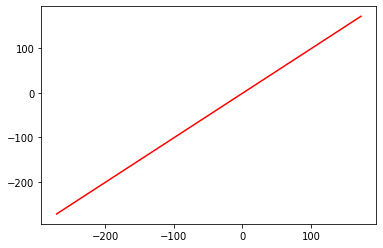

In [40]:
bad_cell_idx = 62
plt.plot(cells[bad_cell_idx ][0], cells[bad_cell_idx ][1], "red");

In [41]:
cells = cells[:bad_cell_idx ] + cells[bad_cell_idx +1:]
treatments = treatments[:bad_cell_idx ] + treatments[bad_cell_idx +1:]
lines = lines[:bad_cell_idx ] + lines[bad_cell_idx +1:]

In [42]:
import numpy as np
import pandas as pd

TREATMENTS = np.unique(treatments)
print(TREATMENTS)
LINES = np.unique(lines)
print(LINES)

['control' 'cytd' 'jasp']
['dlm8' 'dunn']


In [43]:
ds = {}

n_cells_arr = np.zeros((3, 2))

for i, treatment in enumerate(TREATMENTS):
    print(f"{treatment} :")
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = np.array([
            one_treatment == treatment and one_line == line 
            for one_treatment, one_line in zip(treatments, lines)])
        ds[treatment][line] = [cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i]
        nb = len(ds[treatment][line])
        print(f"\t {nb} {line}")
        n_cells_arr[i, j] = nb
        
n_cells_df = pd.DataFrame({
    "dlm8": n_cells_arr[:, 0],
    "dunn": n_cells_arr[:, 1]})
n_cells_df = n_cells_df.set_index(TREATMENTS)

display(n_cells_df)
# display(ds)

control :
	 113 dlm8
	 204 dunn
cytd :
	 82 dlm8
	 93 dunn
jasp :
	 62 dlm8
	 95 dunn


,dlm8,dunn
control,113.0,204.0
cytd,82.0,93.0
jasp,62.0,95.0


In [44]:
print(n_cells_df.loc["control"]["dunn"])
print(len(ds["control"]["dunn"]))

204.0
204


In [45]:
def apply_func_to_ds(input_ds, func):
    output_ds = {}
    for treatment in TREATMENTS:
        output_ds[treatment] = {}
        for line in LINES:
            output_list = []
            for one_cell in input_ds[treatment][line]:
                output_list.append(func(one_cell))
            output_ds[treatment][line] = gs.array(output_list)
    return output_ds

# 3. Preprocessing 

### Interpolation: Encoding discrete curves with same number of points

As we need discrete curves with the same number of sampled points to compute pairwise distances, the following interpolation is applied to each curve, after setting the number of sampling points.

To set up the number of sampling points, you can edit the following line in the next cell:

In [46]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length/nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index)*(curve[(index + 1)%old_length] - curve[index])
        pos += incr
    return interpolation

N_SAMPLING_POINTS = 200

To illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one (to visualize another cell, you can simply re-run the code).

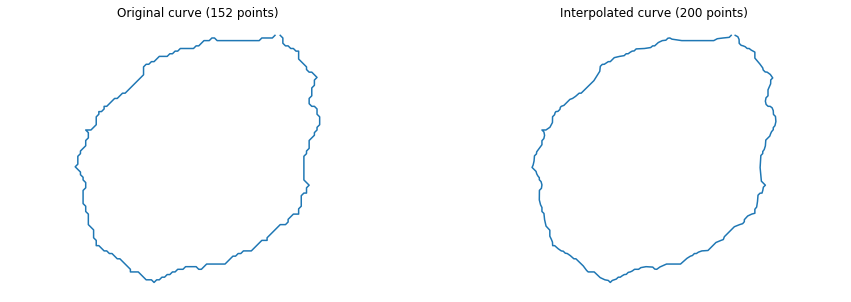

In [47]:
cell_rand = cells[gs.random.randint(len(cells))]
cell_interpolation = interpolate(cell_rand, N_SAMPLING_POINTS)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell_rand[:, 0], cell_rand[:, 1])
plt.axis('equal')
plt.title(f"Original curve ({len(cell_rand)} points)")
plt.axis('off')

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis('equal')
plt.title(f"Interpolated curve ({N_SAMPLING_POINTS} points)")
plt.axis('off');

plt.savefig("interpolation.svg")

In [48]:
# We perform the interpolation on the dictionary of datasets

# ds_interp = {}
# for treatment in TREATMENTS:
#     ds_interp[treatment] = {}
#     for line in LINES:
#         ds_interp[treatment][line] = []
#         for one_cell in ds[treatment][line]:
#             ds_interp[treatment][line].append(interpolate(one_cell, N_SAMPLING_POINTS))
#         ds_interp[treatment][line] = gs.array(ds_interp[treatment][line])

# print(ds_interp["control"]["dunn"].shape)

ds_interp = apply_func_to_ds(input_ds=ds, func=lambda x: interpolate(x, N_SAMPLING_POINTS))

# We also perform it on the list of cells

# for i in range(len(cells)):
#     cells[i] = interpolate(cells[i], nb_sampling)
print(ds_interp["control"]["dunn"].shape)

(204, 200, 2)


### Visualization of interpolated dataset of curves

For a sample of control cells and a sample of treated cells, we hence obtained the following sets of curves (top row shows control, i.e. non-treated cells; bottom row shows treated cells):

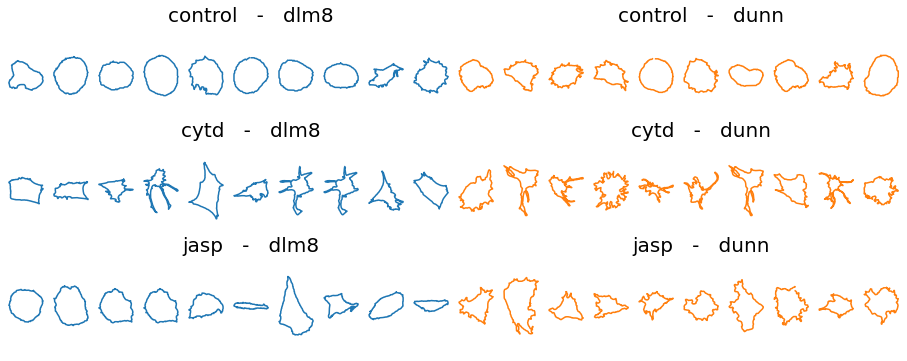

In [49]:
n_cells_to_plot = 10

fig = plt.figure(figsize=(16, 6))
count = 1
for treatment in TREATMENTS:
    for line in LINES:
        cell_data = ds_interp[treatment][line]
        for i_to_plot in range(n_cells_to_plot):
            cell = gs.random.choice(cell_data)
            fig.add_subplot(3, 2 * n_cells_to_plot, count)
            count += 1
            plt.plot(cell[:, 0], cell[:, 1], color="C" + str(int((line=="dunn"))))
            plt.axis('equal')
            plt.axis('off')
            if i_to_plot == n_cells_to_plot // 2:
                plt.title(f"{treatment}   -   {line}", fontsize=20)
plt.savefig("cancer_cell_sample.svg")

Visual inspection of these curves seems to indicate more protusions appearing in treated cells, compared with control ones. This is in agreement with the physiological impact of the drugs, which are known to perturb the internal cytoskeleton connected to the cell membrane. Using the elastic metric, our goal will be to see if we can quantitatively confirm these differences.

### Alignment and re-parametrization

Our goal is to study the cell boundaries in our dataset, as points in a shape space of closed curves quotiented by translation, scaling, and rotation, so these transformations do not affect our measure of distance between curves.

In practice, we apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then align (find the rotation minimizing the L² distance) two sets of landmarks. Since we are working with closed curves, the starting point associated with the parametrization of the discrete curves is also arbitrary. Thus, we conduct an exhaustive search to find which parametrization produces the best alignment according to the above procedure (i.e. the distance to the base curve is the smallest). 

After running this protocol to align all the curves of the dataset against the first one (cf. next two blocks), our set of curves is now processed and ready for the analysis.

In [50]:
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric

M_AMBIENT = 2

PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=N_SAMPLING_POINTS)
PRESHAPE_METRIC = PRESHAPE_SPACE.embedding_metric


def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift)%nb_sampling] for i in range(nb_sampling)]
        aligned = PRESHAPE_SPACE.align(point=reparametrized, base_point=base_curve)
        distances[shift] = PRESHAPE_METRIC.norm(gs.array(aligned) - gs.array(base_curve))
    shift_min = gs.argmin(distances)
    reparametrized_min = [curve[(i + shift_min)%nb_sampling] for i in range(nb_sampling)]
    aligned_curve = PRESHAPE_SPACE.align(point=reparametrized_min, base_point=base_curve)
    return aligned_curve

In [51]:
ds_proj = apply_func_to_ds(ds_interp, func=PRESHAPE_SPACE.projection)
print(ds_proj["control"]["dunn"].shape)

BASE_CURVE = ds_proj["control"]["dunn"][0]
print("Shape of BASE_CURVE:", BASE_CURVE.shape)

ds_align = apply_func_to_ds(ds_proj, func=lambda x: exhaustive_align(x, BASE_CURVE))
print(ds_align["control"]["dunn"].shape)

(204, 200, 2)
Shape of BASE_CURVE: (200, 2)
(204, 200, 2)


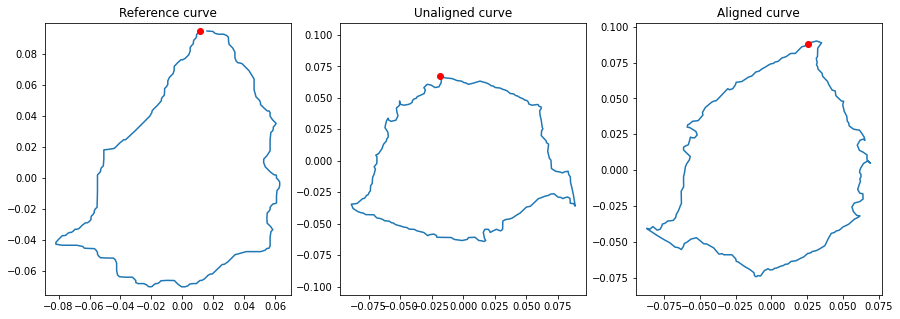

In [52]:
i_rand = gs.random.randint(n_cells_df.loc["control"]["dunn"])
unaligned_cell = ds_proj["control"]["dunn"][i_rand] 
aligned_cell = ds_align["control"]["dunn"][i_rand] 

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])
plt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], 'ro')
plt.axis('equal')
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Aligned curve");

plt.savefig("alignment.svg")

In the plot above, the red dot shows the start of the parametrization of each curve. The right curve has been rotated from the curve in the middle, to be aligned with the left (reference) curve, which represents the first cell of the dataset. The starting point (in red) of this right curve has been also set to align with the reference.

# 4 Data analysis

## Geodesic trajectory joining two cell shapes

Using *Geomstats*, we can compute geodesics between discrete curves with respect to the elastic metric [(SKJJ2010)](#References). In our data, these geodesics represent trajectories between cell boundaries that minimize an elastic energy, and the length of the geodesic defines a distance between curves. We illustrate such a geodesic between two cells (run the block again to get a trajectory joining two other randomly chosen cells):

In [53]:
i_start_rand = gs.random.randint(len(ds_proj["control"]["dunn"]))
i_end_rand = gs.random.randint(len(ds_proj["control"]["dlm8"]))

cell_start = ds_align["control"]["dunn"][i_start_rand]
cell_end = ds_align["control"]["dlm8"][i_end_rand]

print(i_start_rand, i_end_rand)

57 0


In [54]:
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, SRVMetric, ClosedDiscreteCurves, ClosedSRVMetric

CURVES_SPACE = ClosedDiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.square_root_velocity_metric

geodesic = SRV_METRIC.geodesic(initial_curve=cell_start, end_curve=cell_end)

n_times = 30
times = gs.linspace(0., 1., n_times)
geod_points = geodesic(times)

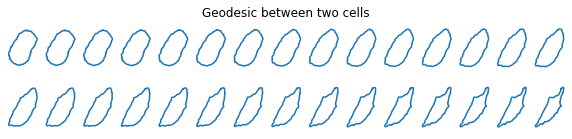

In [55]:
fig = plt.figure(figsize = (10, 2))
plt.title("Geodesic between two cells")
plt.axis('off')

for i, curve in enumerate(geod_points):
    fig.add_subplot(2, n_times/2, i + 1)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis('equal')
    plt.axis('off')
plt.savefig("geodesic_light_blue.svg")

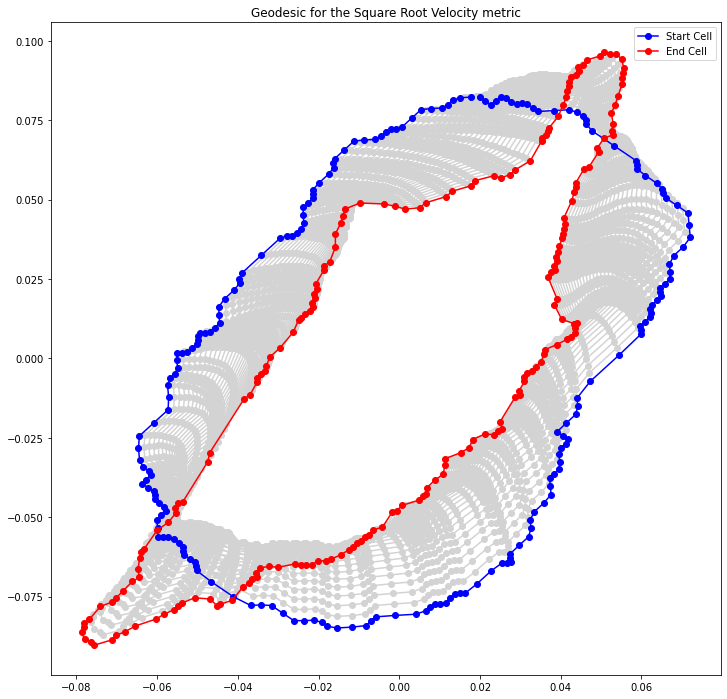

<Figure size 432x288 with 0 Axes>

In [56]:
plt.figure(figsize=(12, 12))
for i in range(1, n_times - 1):
    plt.plot(geod_points[i, :, 0], geod_points[i, :, 1], 'o-', color="lightgrey")
plt.plot(geod_points[0, :, 0], geod_points[0, :, 1], 'o-b', label="Start Cell")
plt.plot(geod_points[-1, :, 0], geod_points[-1, :, 1], 'o-r', label="End Cell")

plt.title('Geodesic for the Square Root Velocity metric')
plt.legend()
plt.show()
plt.savefig("geodesic_blue_red.svg")

In [57]:
# This code does not work well, it might run when playing with the number of sampling points.
# See notebook on 08_shape_analysis for explanations
# If it works, then it quotients out by the reparameterization (resampling of the points) along the curves.

# REPARAM_QUOTIENT_METRIC = CURVES_SPACE.quotient_square_root_velocity_metric

# hgeod_fun = REPARAM_QUOTIENT_METRIC.horizontal_geodesic(cell_start, cell_end)
# hgeod = hgeod_fun(times)

# plt.figure(figsize=(7, 7))
# plt.plot(hgeod[0, :, 0], hgeod[0, :, 1], 'o-b')
# for i in range(1, n_times - 1):
#     plt.plot(hgeod[i, :, 0], hgeod[i, :, 1], 'o-k')
# plt.plot(hgeod[-1, :, 0], hgeod[-1, :, 1], 'o-r')
# plt.title('Horizontal geodesic')
# plt.show()

plotting 0plotting 1
plotting 2
plotting 3
plotting 4
plotting 5plotting 6


plotting 7
plotting 8
plotting 9
plotting 10
plotting 11
plotting 12
plotting 13
plotting 14
plotting 15
plotting 16
plotting 17
plotting 18
plotting 19
plotting 20
plotting 21
plotting 22
plotting 23
plotting 24
plotting 25
plotting 26
plotting 27
plotting 28
plotting 29


1

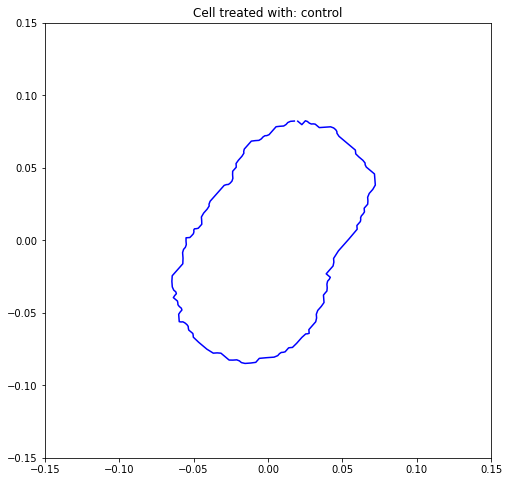

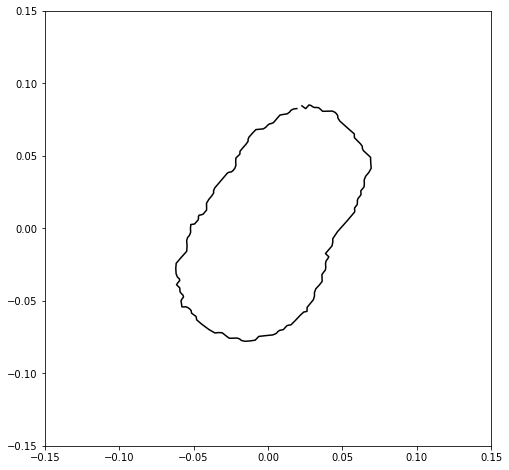

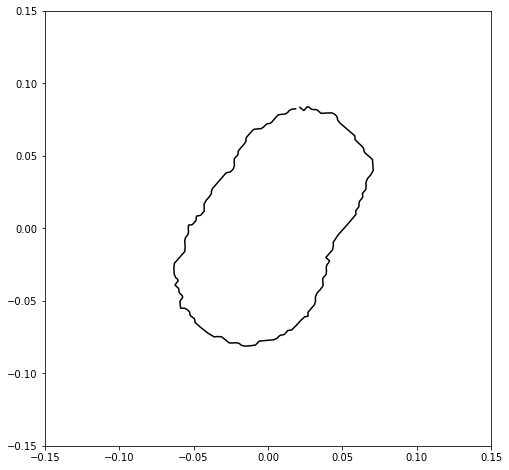

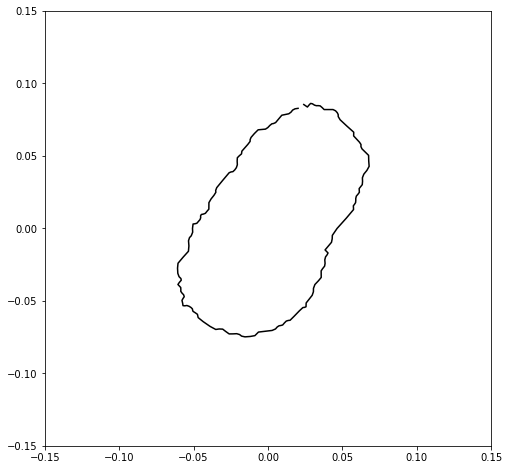

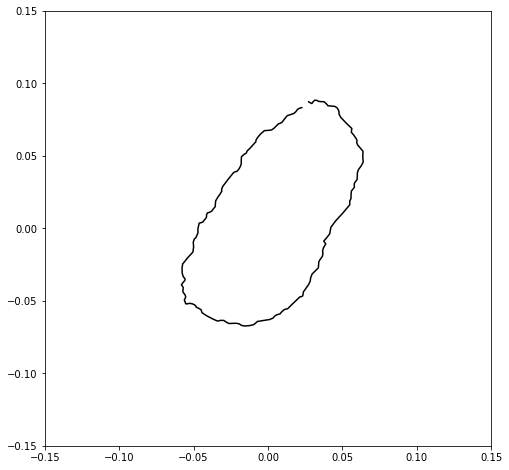

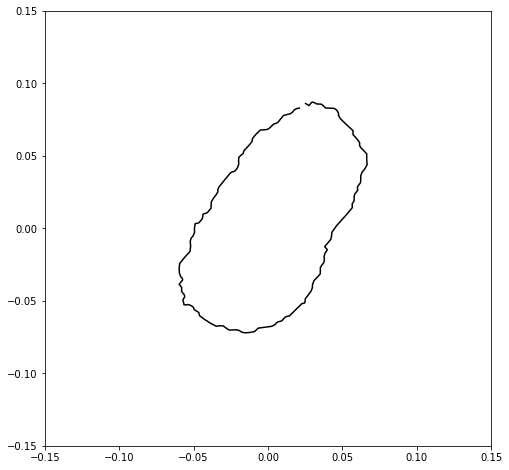

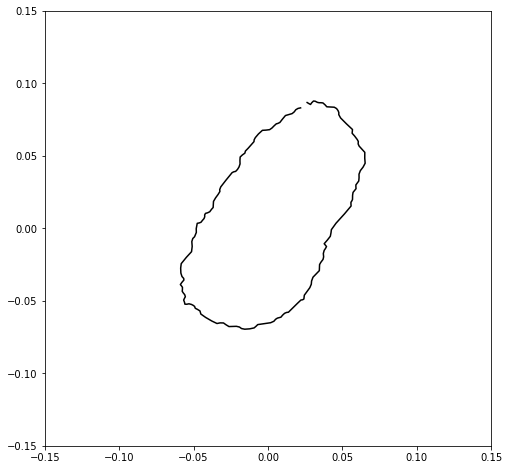

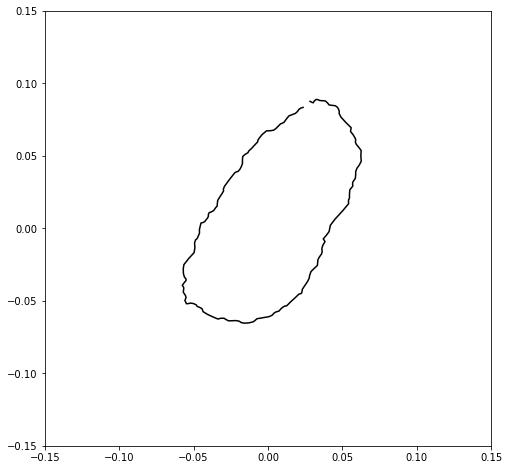

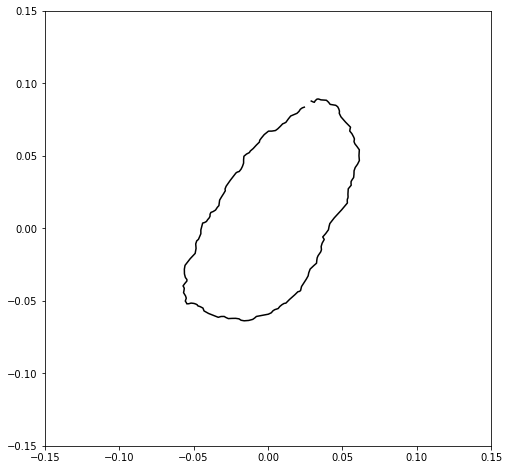

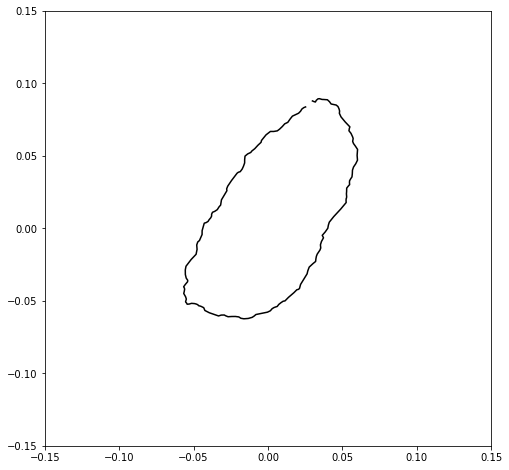

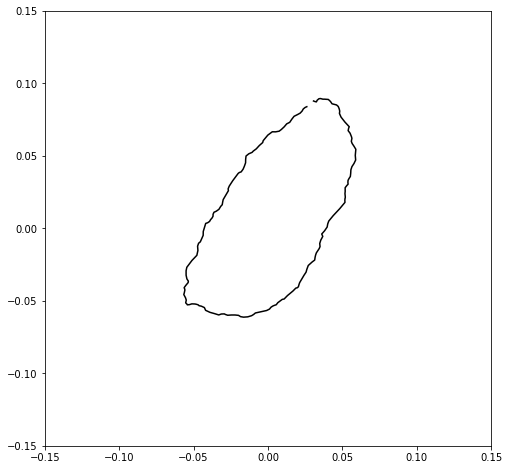

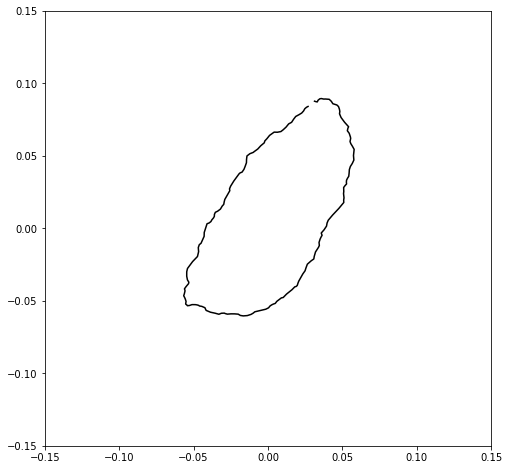

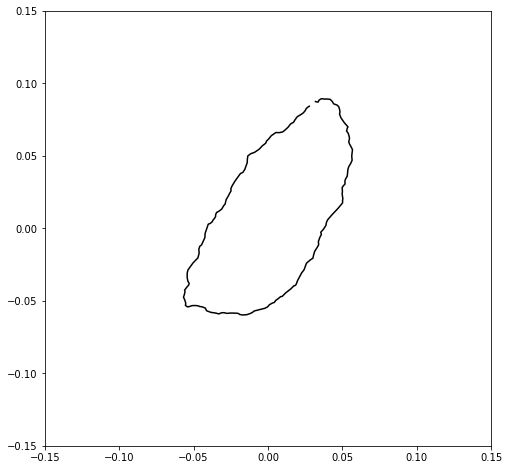

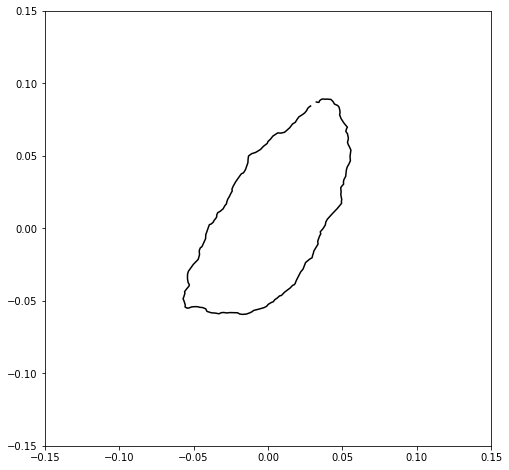

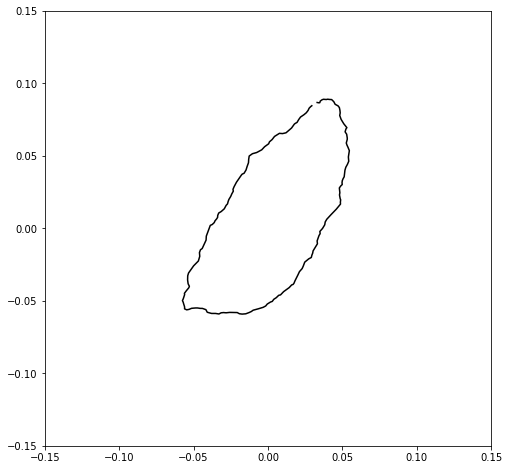

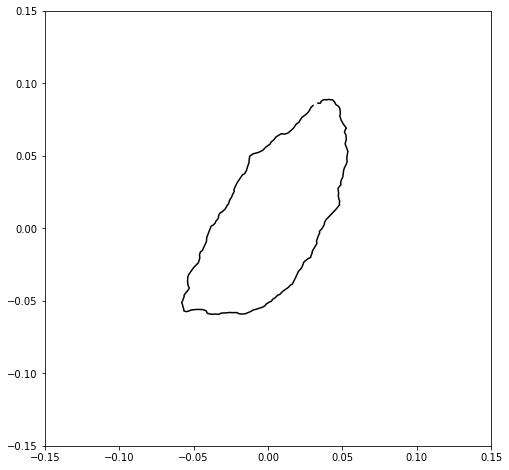

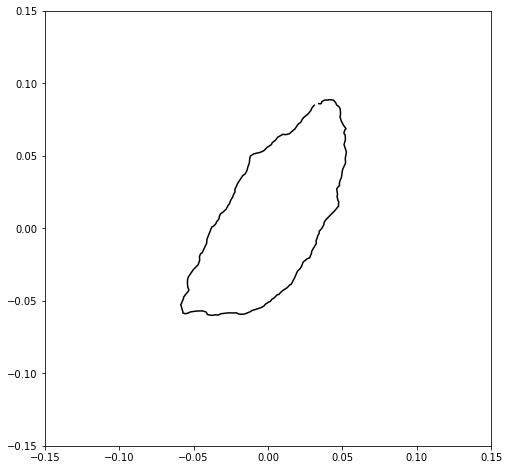

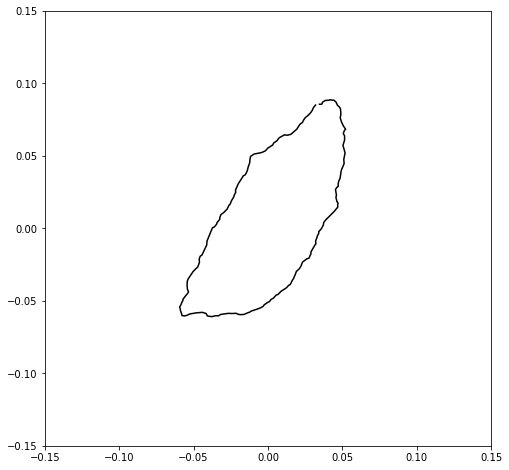

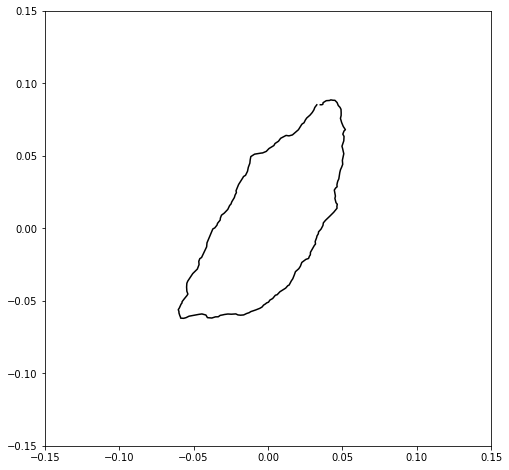

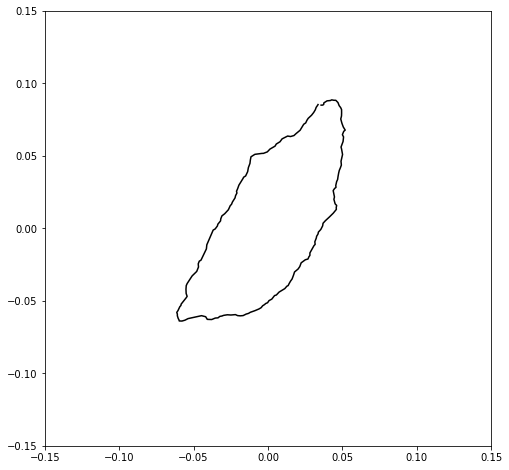

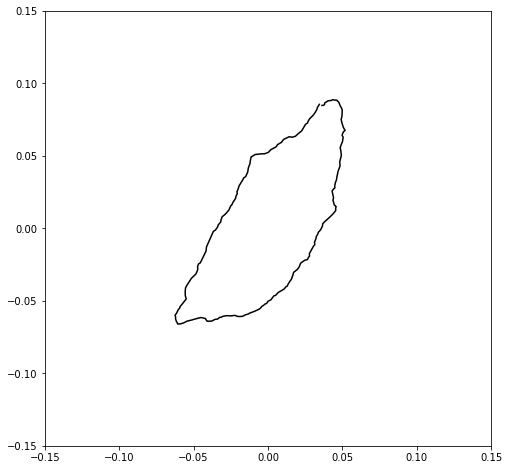

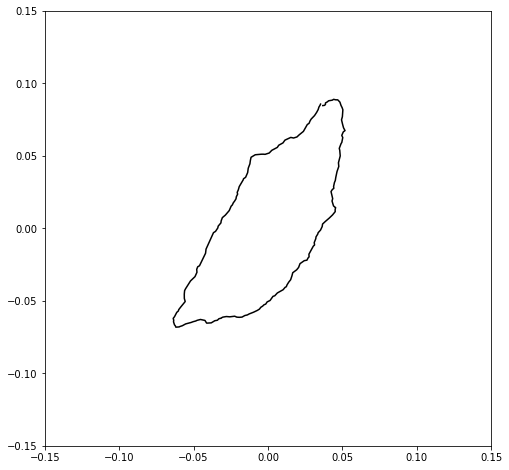

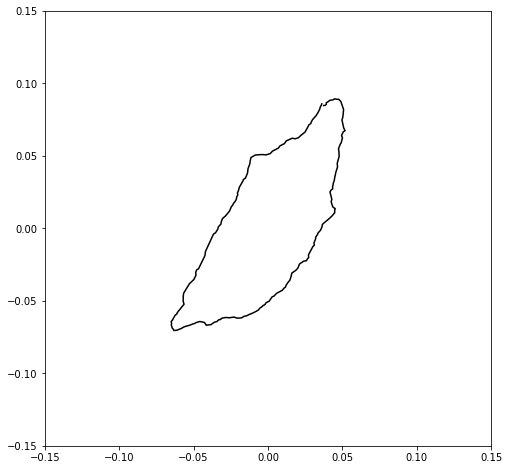

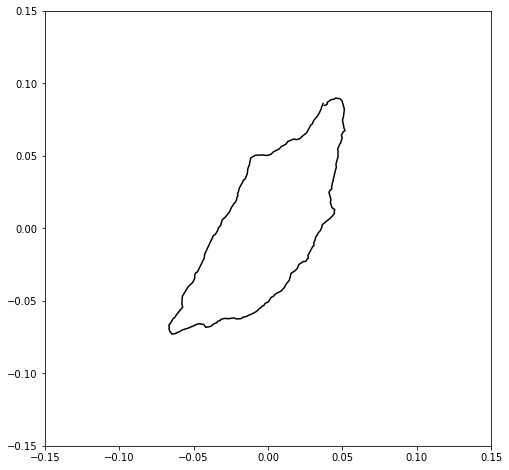

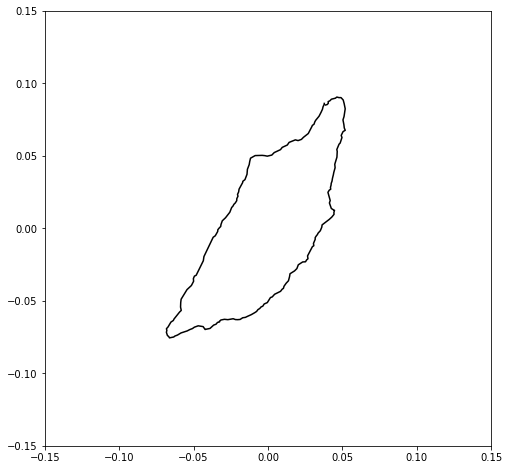

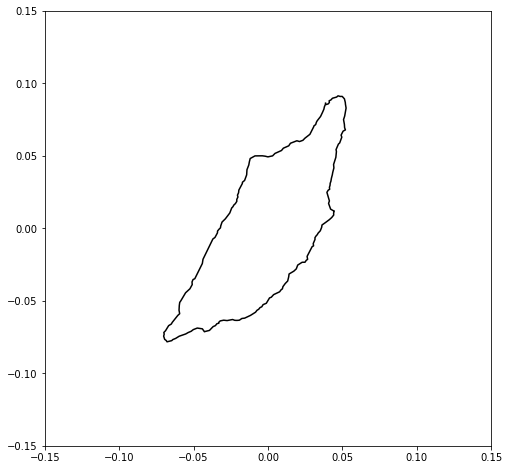

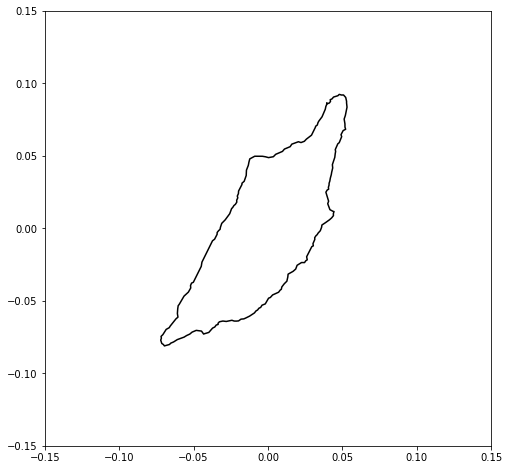

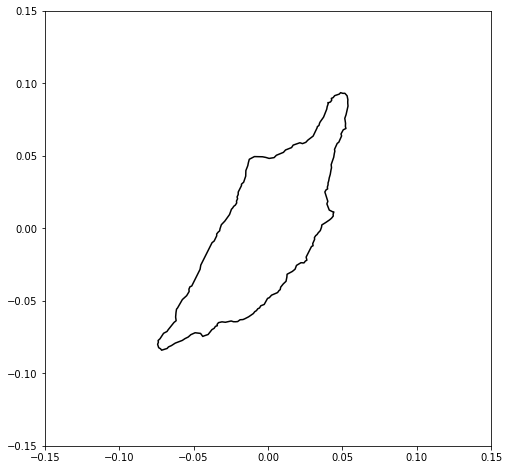

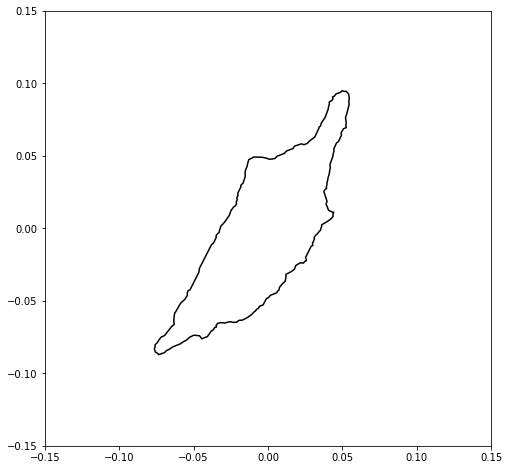

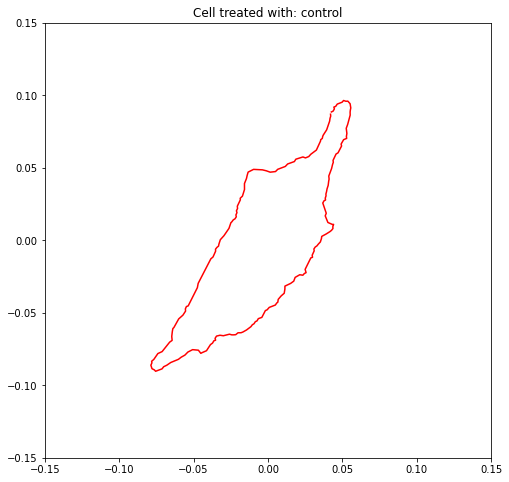

In [58]:
from joblib import Parallel, delayed, parallel_backend
import numpy as np
import matplotlib.pyplot as plt
import os

IMG_PREFIX = "geodesic_a"

def plot_image(i_img):
    print(f"plotting {i_img}")
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    if i_img == 0:
        ax.plot(geod_points[i_img, :, 0], geod_points[i_img, :, 1], '-b')
        ax.set_title(f"Cell treated with: {treatments[i]}")
    elif i_img == n_times-1:
        ax.plot(geod_points[i_img, :, 0], geod_points[i_img, :, 1], '-r')
        ax.set_title(f"Cell treated with: {treatments[j]}")
    else:
        ax.plot(geod_points[i_img, :, 0], geod_points[i_img, :, 1], '-k')
    ax.set_xlim((-0.15, 0.15))
    ax.set_ylim((-0.15, 0.15))
    fig.savefig(f"{IMG_PREFIX}{i_img:04d}.png")
    
with parallel_backend("threading", n_jobs=-1):
    Parallel()(delayed(plot_image)(i_img) for i_img in range(n_times))

os.system(
    f"ffmpeg -i {IMG_PREFIX}%04d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4"
)

## Compute mean cell shape of the whole dataset: "global" mean shape

Compute mean of whole dataset:

In [59]:
cell_shapes_list = []
for treatment in TREATMENTS:
    for line in LINES:
        cell_shapes_list.extend(ds_align[treatment][line])
        
cell_shapes = np.array(cell_shapes_list)
print(cell_shapes.shape)

(649, 200, 2)


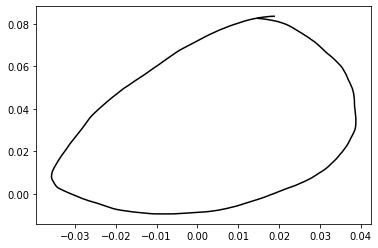

In [60]:
from geomstats.learning.frechet_mean import FrechetMean

mean = FrechetMean(metric=SRV_METRIC, point_type="matrix")
mean.fit(cell_shapes)

mean_estimate = mean.estimate_

plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black");

(649, 200, 2)


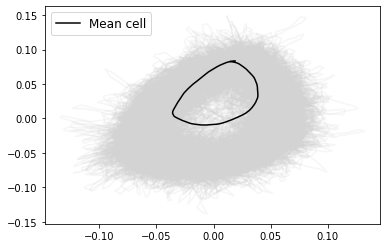

In [61]:
print(cell_shapes.shape)
for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)
    
plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], "black", label="Mean cell")
plt.legend(fontsize=12);

We see that the scale and alignement of the mean shape is slightly off. We correct it manually.

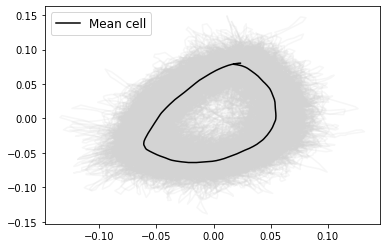

In [62]:
mean_estimate_aligned = 1.55 * (mean_estimate - np.mean(mean_estimate, axis=0))

for cell in cell_shapes:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)
    
plt.plot(mean_estimate_aligned[:, 0], mean_estimate_aligned[:, 1], "black", label="Mean cell")
plt.legend(fontsize=12);

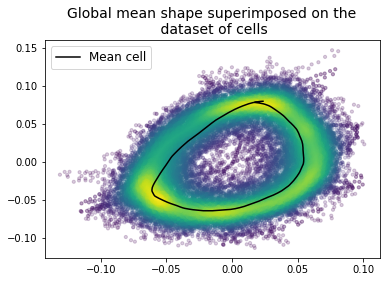

In [63]:
from scipy.stats import gaussian_kde

cells_to_plot = cell_shapes[gs.random.randint(len(cell_shapes), size=200)]
points_to_plot = cells_to_plot.reshape(-1, 2)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / np.max(z)

plt.scatter(points_to_plot[:, 0], points_to_plot[:, 1], alpha=0.2, c=z_norm, s=10)
plt.plot(mean_estimate_aligned[:, 0], mean_estimate_aligned[:, 1], "black", label="Mean cell")
plt.legend(fontsize=12)
plt.title("Global mean shape superimposed on the\n dataset of cells", fontsize=14);

plt.savefig("global_mean_shape.svg")

# Analyze distances to the "global"  mean shape

In [64]:
dists_to_global_mean = apply_func_to_ds(
    ds_align, func=lambda x: SRV_METRIC.dist(x, mean_estimate_aligned)[0])

dists_to_global_mean_list = []
for t in TREATMENTS:
    for l in LINES:
        dists_to_global_mean_list.extend(dists_to_global_mean[t][l])

In [65]:
dists_to_global_mean["control"]["dunn"][:5]

array([ 5.89348254,  5.96186702,  8.46541238,  5.14787129, 10.30239934])

In [66]:
dists_to_global_mean_list[:5]

[6.917814760064295,
 6.424116091221333,
 5.637429760425126,
 5.837927914697139,
 5.248893849745964]

In [67]:
min_dists = min(dists_to_global_mean_list)
max_dists = max(dists_to_global_mean_list)
print(min_dists, max_dists)

4.620053779757737 17.872673961632014


In [68]:
xx = np.linspace(np.floor(min_dists), np.ceil(max_dists), 100)

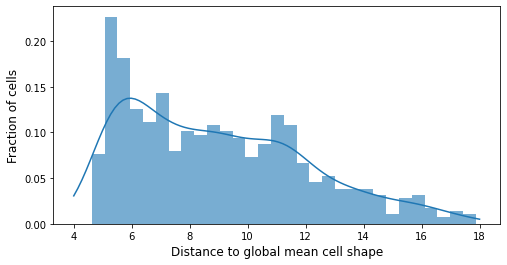

In [69]:
from scipy import stats

plt.figure(figsize=(8, 4))
plt.hist(dists_to_global_mean_list, density=True, bins=30, alpha=0.6)
kde = stats.gaussian_kde(dists_to_global_mean_list)
plt.plot(xx, kde(xx), color="C0")
plt.xlabel("Distance to global mean cell shape", fontsize=12)
plt.ylabel("Fraction of cells", fontsize=12);

plt.savefig("dist_to_global_mean.svg")

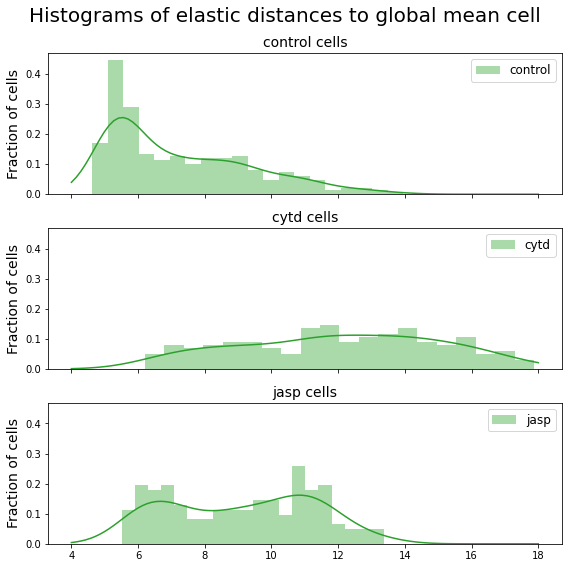

In [70]:
fig, axs = plt.subplots(len(TREATMENTS), sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))    

for i, treatment in enumerate(TREATMENTS):
    distances = []
    for j, line in enumerate(LINES):
        distances.extend(dists_to_global_mean[treatment][line])
    axs[i].hist(distances, bins=20, alpha=0.4, density=True, color="C2", label=treatment)
    kde = stats.gaussian_kde(distances)
    axs[i].plot(xx, kde(xx), color="C2")
    axs[i].legend(fontsize=12)

    axs[i].set_title(f"{treatment} cells", fontsize=14)
    axs[i].set_ylabel("Fraction of cells", fontsize=14)


fig.suptitle("Histograms of elastic distances to global mean cell", fontsize=20);
plt.savefig("dist_to_global_mean_per_treatment.svg")

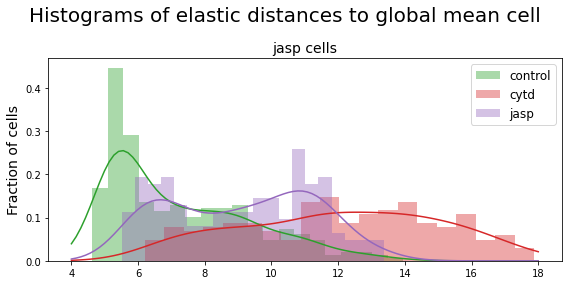

In [71]:
fig, axs = plt.subplots(1, sharex=True, sharey=True, tight_layout=True, figsize=(8, 4))    

for i, treatment in enumerate(TREATMENTS):
    distances = []
    for j, line in enumerate(LINES):
        distances.extend(dists_to_global_mean[treatment][line])
    color = "C" + str(2+i)
    axs.hist(distances, bins=20, alpha=0.4, density=True, color=color, label=treatment)
    kde = stats.gaussian_kde(distances)
    axs.plot(xx, kde(xx), color=color)
    axs.legend(fontsize=12)

    axs.set_title(f"{treatment} cells", fontsize=14)
    axs.set_ylabel("Fraction of cells", fontsize=14)


fig.suptitle("Histograms of elastic distances to global mean cell", fontsize=20);
plt.savefig("dist_to_global_mean_per_treatment2.svg")

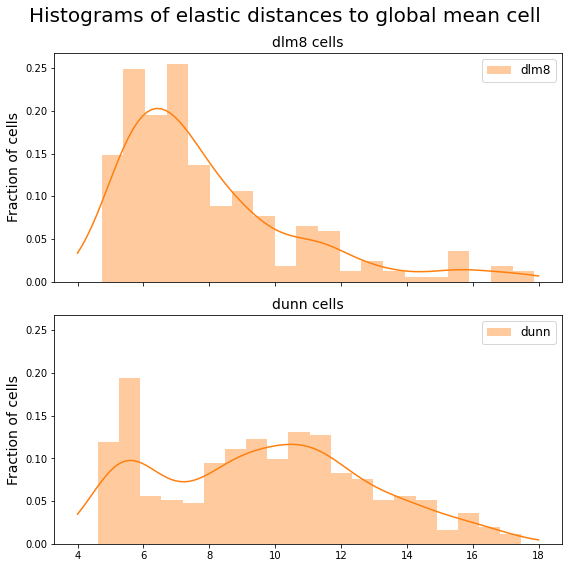

In [72]:
fig, axs = plt.subplots(len(LINES), sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))    

for j, line in enumerate(LINES):
    distances = []
    for i, treatment in enumerate(TREATMENTS):
        distances.extend(dists_to_global_mean[treatment][line])
    axs[j].hist(distances, bins=20, alpha=0.4, density=True, color="C1", label=line)
    kde = stats.gaussian_kde(distances)
    axs[j].plot(xx, kde(xx), color="C1")
    axs[j].legend(fontsize=12)

    axs[j].set_title(f"{line} cells", fontsize=14)
    axs[j].set_ylabel("Fraction of cells", fontsize=14)


fig.suptitle("Histograms of elastic distances to global mean cell", fontsize=20);
plt.savefig("dist_to_global_mean_per_line.svg")

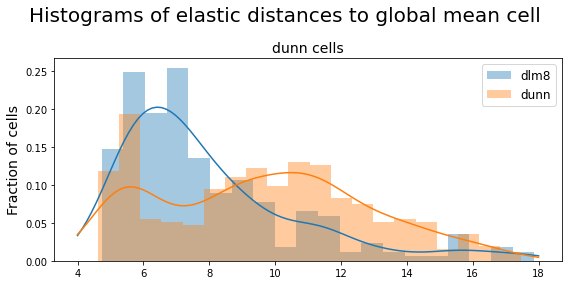

In [73]:
fig, axs = plt.subplots(1, sharex=True, sharey=True, tight_layout=True, figsize=(8, 4))    

for j, line in enumerate(LINES):
    distances = []
    for i, treatment in enumerate(TREATMENTS):
        distances.extend(dists_to_global_mean[treatment][line])
    color = f"C{j}"
    axs.hist(distances, bins=20, alpha=0.4, density=True, color=color, label=line)
    kde = stats.gaussian_kde(distances)
    axs.plot(xx, kde(xx), color=color)
    axs.legend(fontsize=12)

    axs.set_title(f"{line} cells", fontsize=14)
    axs.set_ylabel("Fraction of cells", fontsize=14)


fig.suptitle("Histograms of elastic distances to global mean cell", fontsize=20);
plt.savefig("dist_to_global_mean_per_line2.svg")

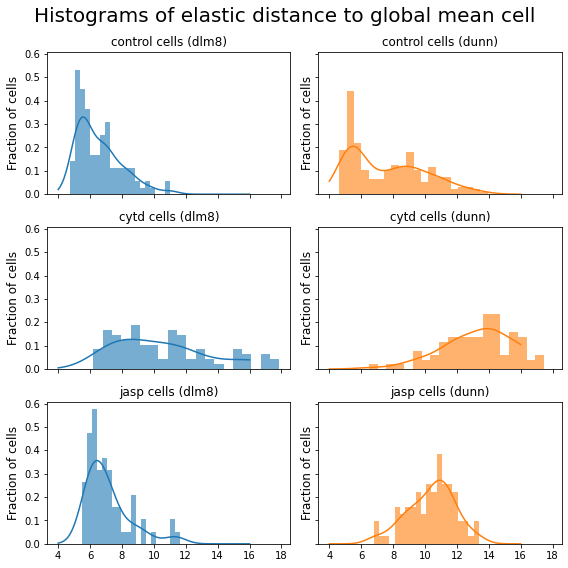

In [74]:
from scipy import stats

fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))

for i, treatment in enumerate(TREATMENTS):
    for j, line in enumerate(LINES):
        distances = dists_to_global_mean[treatment][line]
        color = f"C{j}"
        axs[i, j].hist(distances, bins=20, alpha=0.6, density=True, color=color)
        kde = stats.gaussian_kde(distances)
        xx = np.linspace(4, 16, 100)
        axs[i, j].plot(xx, kde(xx), color=color)
        axs[i, j].set_title(f"{treatment} cells ({line})")
        axs[i, j].set_ylabel("Fraction of cells", fontsize=12)
        
fig.suptitle("Histograms of elastic distance to global mean cell", fontsize=20);
plt.savefig("dist_to_global_mean_per_class.svg")

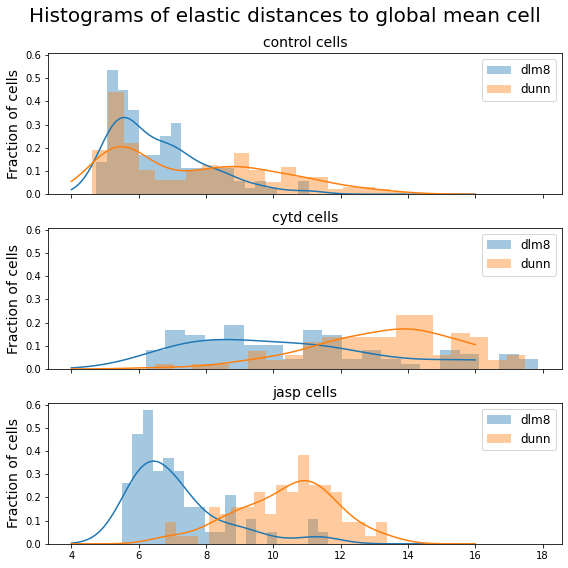

In [75]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))

for i, treatment in enumerate(TREATMENTS):
    for j, line in enumerate(LINES):
        distances = dists_to_global_mean[treatment][line]
        color = f"C{j}"
        axs[i].hist(distances, bins=20, alpha=0.4, density=True, color=color, label=line)
        kde = stats.gaussian_kde(distances)
        xx = np.linspace(4, 16, 100)
        axs[i].plot(xx, kde(xx), color=color)
        
    axs[i].set_title(f"{treatment} cells", fontsize=14)
    axs[i].set_ylabel("Fraction of cells", fontsize=14)
    axs[i].legend(fontsize=12)

fig.suptitle("Histograms of elastic distances to global mean cell", fontsize=20);
plt.savefig("dist_to_global_mean_per_class2.svg")

# Hypothesis testing on equality of means

In [76]:
import scipy

In [77]:
line_1, line_2 = LINES

print(f"\n --- Test equality of means: {line_1} vs {line_2}")
dists_1 = []
for treatment_1 in TREATMENTS:
    dists_1.extend(dists_to_global_mean[treatment_1][line_1])
dists_1 = np.array(dists_1)

dists_2 = []
for treatment_2 in TREATMENTS:
    dists_2.extend(dists_to_global_mean[treatment_2][line_2])
dist_2 = np.array(dists_2)

display(scipy.stats.ttest_ind(dists_1, dists_2, equal_var=False))


 --- Test equality of means: dlm8 vs dunn


Ttest_indResult(statistic=-7.096039312054575, pvalue=3.63854609285711e-12)

In [78]:
count = 0

from itertools import combinations

for two_treatments in combinations(TREATMENTS, 2):
    treatment_1, treatment_2 = two_treatments

    print(f"\n --- Test equality of means: {treatment_1} vs {treatment_2}")
    dists_1 = []
    for line_1 in LINES:
        dists_1.extend(dists_to_global_mean[treatment_1][line_1])
    dists_1 = np.array(dists_1)

    dists_2 = []
    for line_2 in LINES:
        dists_2.extend(dists_to_global_mean[treatment_2][line_2])
    dist_2 = np.array(dists_2)

    display(scipy.stats.ttest_ind(dists_1, dists_2, equal_var=False))
    count += 1
print(f"!! Correct for multiple hypothesis testing with Bonferroni correction,"
f" by multiplying the p-values by {count} ")


 --- Test equality of means: control vs cytd


Ttest_indResult(statistic=-18.82268430653188, pvalue=3.55058863405708e-51)


 --- Test equality of means: control vs jasp


Ttest_indResult(statistic=-8.84924806515692, pvalue=7.372423554996374e-17)


 --- Test equality of means: cytd vs jasp


Ttest_indResult(statistic=10.357795388362065, pvalue=7.662632588294853e-22)

!! Correct for multiple hypothesis testing with Bonferroni correction, by multiplying the p-values by 3 


In [79]:
TREATMENT_LINE_CLASSES = set([(t, l) for t in TREATMENTS for l in LINES])

In [80]:
count = 0

for two_classes in combinations(TREATMENT_LINE_CLASSES, 2):
    class_1, class_2 = two_classes
    treatment_1, line_1 = class_1
    treatment_2, line_2 = class_2
    print(f"\n --- Test equality of means: {treatment_1}-{line_1} vs {treatment_2}-{line_2}")
    display(scipy.stats.ttest_ind(
        dists_to_global_mean[treatment_1][line_1],
        dists_to_global_mean[treatment_2][line_2], equal_var=False))
    count += 1
print(
    f"!! Correct for multiple hypothesis testing with Bonferroni correction,"
    f" by multiplying the p-values by {count} ")


 --- Test equality of means: jasp-dlm8 vs cytd-dlm8


Ttest_indResult(statistic=-8.99062926107038, pvalue=4.328879230292363e-15)


 --- Test equality of means: jasp-dlm8 vs control-dlm8


Ttest_indResult(statistic=2.444198536029385, pvalue=0.01592604470670971)


 --- Test equality of means: jasp-dlm8 vs control-dunn


Ttest_indResult(statistic=-2.052381842429565, pvalue=0.04166595239043246)


 --- Test equality of means: jasp-dlm8 vs jasp-dunn


Ttest_indResult(statistic=-13.924481915247364, pvalue=6.934605850110651e-28)


 --- Test equality of means: jasp-dlm8 vs cytd-dunn


Ttest_indResult(statistic=-21.375534685397774, pvalue=9.06528363481703e-48)


 --- Test equality of means: cytd-dlm8 vs control-dlm8


Ttest_indResult(statistic=10.975831240168672, pvalue=3.9998002076157e-19)


 --- Test equality of means: cytd-dlm8 vs control-dunn


Ttest_indResult(statistic=7.834893995940149, pvalue=2.0809541688830962e-12)


 --- Test equality of means: cytd-dlm8 vs jasp-dunn


Ttest_indResult(statistic=0.4921465531618568, pvalue=0.6235726071190382)


 --- Test equality of means: cytd-dlm8 vs cytd-dunn


Ttest_indResult(statistic=-6.726305610607777, pvalue=3.7492701057970527e-10)


 --- Test equality of means: control-dlm8 vs control-dunn


Ttest_indResult(statistic=-4.9663295910771685, pvalue=1.1229595439515043e-06)


 --- Test equality of means: control-dlm8 vs jasp-dunn


Ttest_indResult(statistic=-19.03967948304338, pvalue=2.4785081746834548e-46)


 --- Test equality of means: control-dlm8 vs cytd-dunn


Ttest_indResult(statistic=-25.643979731569406, pvalue=1.9849002897277001e-56)


 --- Test equality of means: control-dunn vs jasp-dunn


Ttest_indResult(statistic=-12.4095962131029, pvalue=2.7413266268568353e-28)


 --- Test equality of means: control-dunn vs cytd-dunn


Ttest_indResult(statistic=-20.303062826249647, pvalue=2.7915287442623585e-49)


 --- Test equality of means: jasp-dunn vs cytd-dunn


Ttest_indResult(statistic=-10.701086102925348, pvalue=1.6406584891187998e-20)

!! Correct for multiple hypothesis testing with Bonferroni correction, by multiplying the p-values by 15 


# Distance to means of each treatment

In [81]:
mean_treatment_cells = {}
for treatment in TREATMENTS:
    treatment_cells = []
    for line in LINES:
        treatment_cells.extend(ds_align[treatment][line])
    mean_estimator = FrechetMean(metric=SRV_METRIC, point_type="matrix")
    mean_estimator.fit(treatment_cells)
    mean_treatment_cells[treatment] = mean_estimator.estimate_

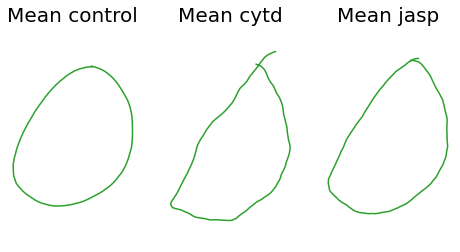

In [82]:
fig = plt.figure(figsize=(8, 4))
count = 1
for treatment in TREATMENTS:
        mean_cell = mean_treatment_cells[treatment]
        fig.add_subplot(1, len(TREATMENTS), count)
        count += 1
        plt.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C2")
        plt.axis('equal')
        plt.axis('off')
        plt.title(f"Mean {treatment}", fontsize=20)
plt.savefig("cancer_mean_treatment_cells.svg")

In [83]:
mean_line_cells = {}
for line in LINES:
    line_cells = []
    for treatment in TREATMENTS:
        line_cells.extend(ds_align[treatment][line])
    mean_estimator = FrechetMean(metric=SRV_METRIC, point_type="matrix")
    mean_estimator.fit(line_cells)
    mean_line_cells[line] = mean_estimator.estimate_

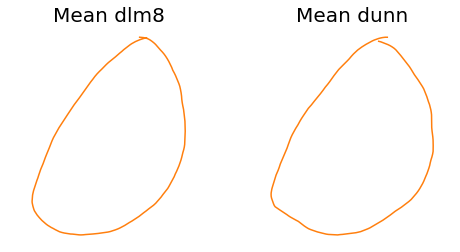

In [84]:
fig = plt.figure(figsize=(8, 4))
count = 1
for line in LINES:
    mean_cell = mean_line_cells[line]
    fig.add_subplot(1, len(LINES), count)
    count += 1
    plt.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C1")
    plt.axis('equal')
    plt.axis('off')
    plt.title(f"Mean {line}", fontsize=20)
plt.savefig("cancer_mean_line_cells.svg")

In [85]:
dists_to_treatment_mean = {}

for treatment in TREATMENTS:
    dists_list = []
    for line in LINES:
        for curve in ds_align[treatment][line]:
            dists_list.append(SRV_METRIC.dist(curve, mean_treatment_cells[treatment])[0])
    dists_to_treatment_mean[treatment] = dists_list

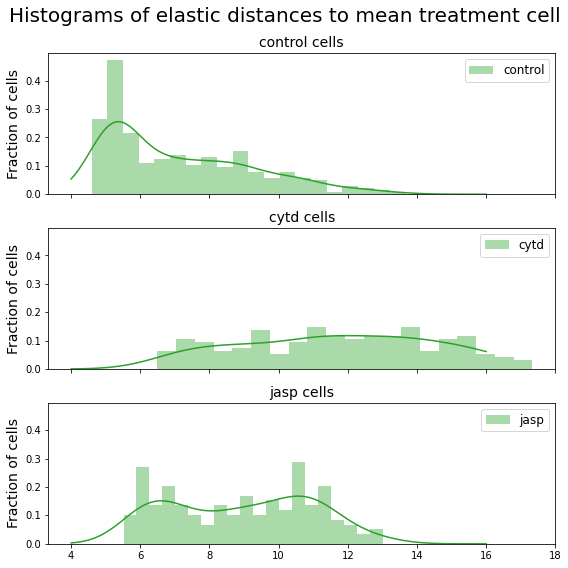

In [86]:
fig, axs = plt.subplots(len(TREATMENTS), sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))    

for i, treatment in enumerate(TREATMENTS):
    distances = dists_to_treatment_mean[treatment]
    axs[i].hist(distances, bins=20, alpha=0.4, density=True, color="C2", label=treatment)
    kde = stats.gaussian_kde(distances)
    axs[i].plot(xx, kde(xx), color="C2")
    axs[i].legend(fontsize=12)

    axs[i].set_title(f"{treatment} cells", fontsize=14)
    axs[i].set_ylabel("Fraction of cells", fontsize=14)


fig.suptitle("Histograms of elastic distances to mean treatment cell", fontsize=20);
plt.savefig("dist_to_treatment_mean_per_treatment.svg")

In [87]:
dists_to_line_mean = {}

for line in LINES:
    dists_list = []
    for treatment in TREATMENTS:
        for curve in ds_align[treatment][line]:
            dists_list.append(SRV_METRIC.dist(curve, mean_line_cells[line])[0])
    dists_to_line_mean[line] = dists_list

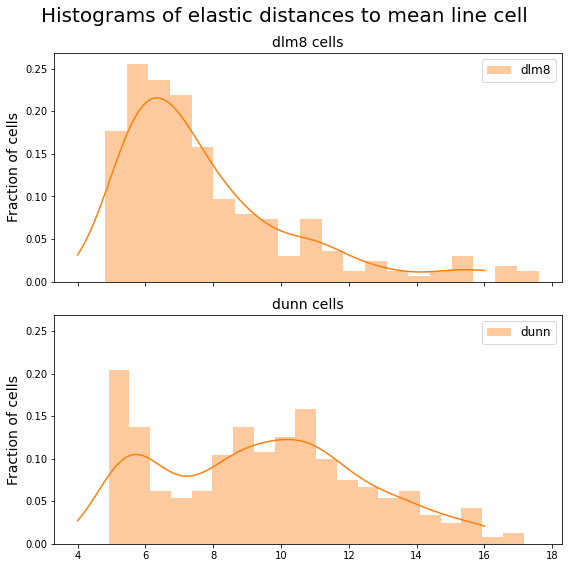

In [88]:
fig, axs = plt.subplots(len(LINES), sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))    

for j, line in enumerate(LINES):
    distances = dists_to_line_mean[line]
    axs[j].hist(distances, bins=20, alpha=0.4, density=True, color="C1", label=line)
    kde = stats.gaussian_kde(distances)
    axs[j].plot(xx, kde(xx), color="C1")
    axs[j].legend(fontsize=12)

    axs[j].set_title(f"{line} cells", fontsize=14)
    axs[j].set_ylabel("Fraction of cells", fontsize=14)


fig.suptitle("Histograms of elastic distances to mean line cell", fontsize=20);
plt.savefig("dist_to_line_mean_per_line.svg")

# Distance to means of each subclass

In [89]:
mean_cells = {}
for treatment in TREATMENTS:
    mean_cells[treatment] = {}
    for line in LINES:
        mean_estimator = FrechetMean(metric=SRV_METRIC, point_type="matrix")
        mean_estimator.fit(ds_align[treatment][line])
        mean_cells[treatment][line] = mean_estimator.estimate_

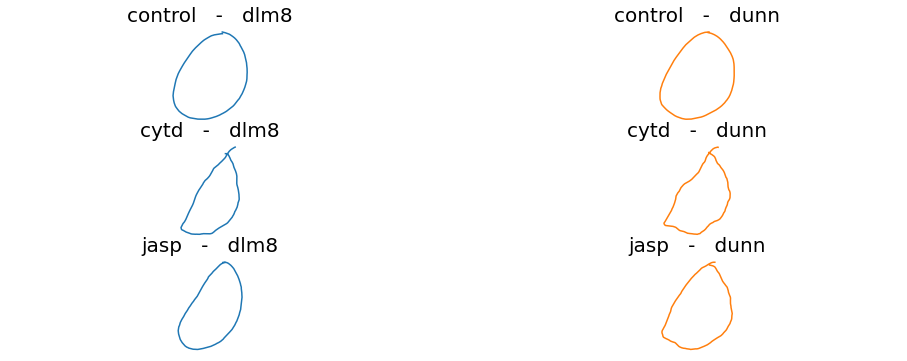

In [90]:
fig = plt.figure(figsize=(16, 6))
count = 1
for treatment in TREATMENTS:
    for j, line in enumerate(LINES):
        mean_cell = mean_cells[treatment][line]
        fig.add_subplot(len(TREATMENTS), len(LINES), count)
        count += 1
        plt.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C{j}")
        plt.axis('equal')
        plt.axis('off')
        plt.title(f"{treatment}   -   {line}", fontsize=20)
plt.savefig("cancer_mean_cells.svg")

In [91]:
dists_to_own_mean = {}
for treatment in TREATMENTS:
    dists_to_own_mean[treatment] = {}
    for line in LINES:
        dists = []
        for curve in ds_align[treatment][line]:
            dists.append(SRV_METRIC.dist(curve, mean_cells[treatment][line])[0])
        dists_to_own_mean[treatment][line] = dists

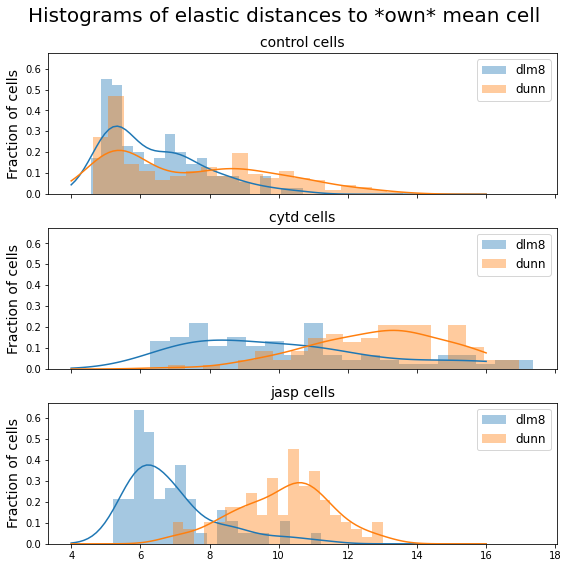

In [92]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, tight_layout=True, figsize=(8, 8))

for i, treatment in enumerate(TREATMENTS):
    for j, line in enumerate(LINES):
        distances = dists_to_own_mean[treatment][line]
        color = f"C{j}"
        axs[i].hist(distances, bins=20, alpha=0.4, density=True, color=color, label=line)
        kde = stats.gaussian_kde(distances)
        xx = np.linspace(4, 16, 100)
        axs[i].plot(xx, kde(xx), color=color)
        
    axs[i].set_title(f"{treatment} cells", fontsize=14)
    axs[i].set_ylabel("Fraction of cells", fontsize=14)
    axs[i].legend(fontsize=12)

fig.suptitle("Histograms of elastic distances to *own* mean cell", fontsize=20);
plt.savefig("dist_to_own_mean.svg")